In [1]:
# number of buckets
NUMBER_OF_BUCKETS = 20

delta = 0.5
k = 1 / delta

In [2]:
import random
import math
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import time
import pandas as pd

## Dataset Preparation

In [3]:
# read dataset
path = '../dataset/data13to17Feb2018.csv'
df = pd.read_csv(path, usecols=['Time', 'Source', 'Destination', 'Protocol', 'Length']).dropna()

# keep only the columns that we want
df = df[['Time', 'Length']]

# transform time column to datetime object
df['Time']= pd.to_datetime(df['Time'])

In [4]:
# we want to disregard the records which have as date 1970
df['Year'] = df['Time'].dt.year
df = df[df['Year'] > 1970]
df = df[['Time', 'Length']]

In [5]:
# check how the dataset looks like
df.head()

,Time,Length
0,2019-02-13 02:13:38.346809,152
1,2019-02-13 02:13:38.347297,40
2,2019-02-13 02:13:38.678841,88
3,2019-02-13 02:13:38.679018,40
4,2019-02-13 02:16:38.390502,152


## Get a slice of the whole dataset

In [6]:
# get a slice of ... records
sliced_df = df[200000:300000]

In [7]:
# get the actual dataset
dataset = []
for index, row in sliced_df.iterrows():
    dataset.append((row['Time'], row['Length']))

#### Copy of the sliced dataset to make the validation

In [8]:
# get all the lengths of the sliced dataset and sort them
cp_dataset = list(sliced_df['Length'])
sorted_cp_dataset = sorted(cp_dataset)

# create the buckets of the actual data
# in each bucket there is an equal amount of records
step = int(len(sorted_cp_dataset) / NUMBER_OF_BUCKETS)
temp_cp_dataset = []
for i in range(0, len(sorted_cp_dataset)-1, step):
    temp_cp_dataset.append(sorted_cp_dataset[i])

# add the last records value as the last upper limit
max_cp_dataset = sorted_cp_dataset[-1]
temp_cp_dataset.append(max_cp_dataset)

## Helping functions

In [9]:
# function for finding in which bar the item should be placed
def find_appropriate_bar_for_item(item):
    # interval: Timestamp
    interval = item[0]
    # length of the packet
    value = item[1]
    
    # if there are no bars in the database, make some initializations
    if len(bars) == 0:
        bars.append(0)
        bars_dic[0] = [value, value, 1]
        EH_dic[0] = [[interval, 1]]
        blocked_bars_dic[0] = []
        return -1
    # if there is at least 1 bar
    else:
        # check one by one the bars to find the one that the record belongs
        for bar in bars:
            if value >= bars_dic[bar][0] and value <= bars_dic[bar][1]:
                return bar
        # if the length value is lower than the lowest boundary of the 1st bar
        # return the 1st bar
        if value < bars_dic[bars[0]][0]:
            bars_dic[bars[0]][0] = value
            return bars[0]
        # if the length valus is higher than the highest boundary of the last bar
        # return the last bar
        if value > bars_dic[bars[-1]][1]:
            bars_dic[bars[-1]][1] = value
            return bars[-1]

In [10]:
def insert_item_to_bar(item, bar):
    interval = item[0]
    value = item[1]
    
    # increase the size of the bar by 1
    bars_dic[bar][2] += 1    
    
    # insert a new box in the exponential histogram dictionary
    EH_dic[bar].append([interval,1])
    
    # keep all boxes of the specific bar
    all_boxes = EH_dic[bar]    
    
    merge_flag = True
    while merge_flag:
        merge_flag = False
        
        # iterate over all of the boxes from the most recent to the oldest
        for i in range(len(all_boxes)-1, -1, -1):
            
            # size of the current box
            size = all_boxes[i][1]
            
            # keep the current index of the box
            j = i
            
            # with this iteration we find how many boxes (going backwards)
            # have the same size with the current one
            count = 0
            while j >= 0:
                j -= 1
                if all_boxes[j][1] == size:
                    count += 1
                else:
                    break
            
            # if the number of the boxes exceed the formula given in the if-conditions
            # then we have to merge boxes
            # k = 1 / delta
            if size == 1:
                if count > k / 2 + 1:
                    merge_flag = True
                    break
            else:
                if count > k / 2 + 2:
                    merge_flag = True
                    break
                    
        # merging the 2 oldest boxes
        if merge_flag:
            
            # oldest box
            last_box_index = j + 1
            last_box = all_boxes[last_box_index]
            
            # second oldest box
            second_last_box_index = j + 2
            second_last_box = all_boxes[second_last_box_index]
            
            # the new box keeps the timestamp of the oldest box and the sum of the sizes
            new_box = [last_box[0], last_box[1] + second_last_box[1]]
            
            # remove old boxes
            all_boxes.pop(second_last_box_index)
            all_boxes.pop(last_box_index)
            
            # insert the new merged box
            all_boxes.insert(last_box_index, new_box)
        else:
            merge_flag = False

In [11]:
def remove_expired_boxes(current_interval, W):
    # iterate over the bars
    for bar in bars:
        
        # take each bar's boxes
        bars_boxes = EH_dic[bar]
        
        # iterate over the boxes from the newest to the oldest and keep the current_index
        current_i = -1
        for i in range(len(bars_boxes)-1, -1, -1):
            
            # if the current interval is greater than the timestamp of a box
            # i.e. if a box has a timestamp which is expired
            # stop the iteration and remove this bar
            if bars_boxes[i][0] < current_interval:
                current_i = i
                break
        
        # if there is something to delete
        if current_i != -1:
            new_boxes = bars_boxes[i+1:]
            old_boxes = bars_boxes[:i+1]
            
            # decrease the size of the current window W by the size of the removed box
            for old_box in old_boxes:
                W = W - old_box[1]
                
            # replace the exponentional histogram dictionary with the non expired boxes
            EH_dic[bar] = new_boxes
            
    return W

In [12]:
def computeBoundaries():
        
    total_Est = 0
    
    for bar in bars:
        bar_size = bars_dic[bar][2]
        total_Est += bar_size
    
    boundaries = [bars_dic[bars[0]][0]]
    b = - 1
    count = 0
    ideal_Buck_Size = total_Est / B
        
    for i in range(B-1):
        while(count <= ideal_Buck_Size):
            b += 1
            count += bars_dic[bars[b]][2]

        surplus = count - ideal_Buck_Size

        temp = bars_dic[bars[b]][0] + (bars_dic[bars[b]][1] - bars_dic[bars[b]][0]) * (1 - surplus/bars_dic[bars[b]][2])

        boundaries.append(temp)
        count = surplus
        
    boundaries.append(bars_dic[bars[-1]][1])

    return boundaries, ideal_Buck_Size

In [13]:
def findBarsToMerge():
    
    # we look for any two empty adjacent bars
    for i in range(len(bars)-1):
        current_bar_size = bars_dic[bars[i]][2]
        next_bar_size = bars_dic[bars[i+1]][2]
        if current_bar_size == 0 and next_bar_size == 0:
            return [i, i+1]
    
    #If there is no such pair, we look for an empty bar and merge it with the smaller of its two neighbors
    for i in range(len(bars)-1):
        current_bar_size = bars_dic[bars[i]][2]
        next_bar_size = bars_dic[bars[i+1]][2]
        if current_bar_size == 0:
            if i >= 1:
                previous_bar = i - 1
                next_bar = i + 1
                previous_bar_size = bars_dic[bars[previous_bar]][2]
                next_bar_size = bars_dic[bars[next_bar]][2]
                if previous_bar_size <= next_bar_size:
                    if previous_bar_size < maxSize:
                        return [previous_bar, i]
                else:
                    if next_bar_size < maxSize:
                        return [i, next_bar]
            else:
                if next_bar_size < maxSize:
                    return [i, i+1]
    
    # When there is no empty bar, then we find the two adjacent bars that have the min-
    # imum aggregate size. If this aggregate size is less than maxSize (which is usually the case), 
    # we select them for merging.
    
    min_agg_size = sys.maxsize
    current_index = -1
    for i in range(len(bars)-1):
        current_bar_size = bars_dic[bars[i]][2]
        next_bar_size = bars_dic[bars[i+1]][2]
        if current_bar_size + next_bar_size < min_agg_size:
            min_agg_size = current_bar_size + next_bar_size
            current_index = i
    
    if min_agg_size < maxSize:
        return [current_index, current_index + 1]
    
    # Otherwise, we do not perform any merge operations until some boxes
    # expire, since we do not want to create bars with size greater than maxSize.
    
    return [None, None]

In [14]:
def mergeBars():
    
    X_l_index, X_r_index = findBarsToMerge()
    
    # if there are no bars to merge
    if X_l_index is None or X_r_index is None:
        return False
    
    X_l = bars[X_l_index]
    X_r = bars[X_r_index]
        
    # new bar X
    X = [0, 0, 0]
    X_name = max(bars) + 1
    
    if len(EH_dic[X_l]) >= len(EH_dic[X_r]):
        EH_dic[X_name] = EH_dic[X_r]
        blocked_bars_dic[X_name] = [X_l]
    else:
        EH_dic[X_name] = EH_dic[X_l]
        blocked_bars_dic[X_name] = [X_r]
    
    temp_list = blocked_bars_dic[X_l] + blocked_bars_dic[X_r]
    blocked_bars_dic[X_name].extend(temp_list)
    
    # lower bound =  left bar lower bound
    X[0] = bars_dic[X_l][0]
    
    # upper bound = right bar upper bound
    X[1] = bars_dic[X_r][1]
    
    # sum of the sizes
    X[2] = bars_dic[X_l][2] + bars_dic[X_r][2]
    
    # remove old bars
    bars.pop(X_r_index)
    bars.pop(X_l_index)
    
    # insert the new bar
    bars.insert(X_l_index, X_name)
    
    bars_dic[X_name] = X
    
    return True

In [15]:
def splitBar(X):
    
    if len(bars) == Sm and not mergeBars():
        return
    
    X_l = [0, 0, 0]
    X_r = [0, 0, 0]
    
    l = 0
    
    # distributing blocked bars of X between the new bars
    blocked_bars_X_l = []
    blocked_bars_X_r = []
    EH_X_l = []
    EH_X_r = []
    
    # aggregate size of the blocked bars
    BBSize = 0
    if len(blocked_bars_dic[X]) != 0:
        for bbar in blocked_bars_dic[X]:
            BBSize += int(bars_dic[bbar][2])
    
    for bbar in blocked_bars_dic[X]:
        bbar_size = bars_dic[bbar][2]
        if l + bbar_size < BBSize/2:
            l += bbar_size
            blocked_bars_X_l.append(bbar)
        else:
            blocked_bars_X_r.append(bbar)
            
    X_l[0] = bars_dic[X][0]
    X_l[1] = (bars_dic[X][0] + bars_dic[X][1]) / 2
    X_r[0] = (bars_dic[X][0] + bars_dic[X][1]) / 2
    X_r[1] = bars_dic[X][1]
    
    
    try:
        Ratio = (bars_dic[X][2] / 2 -l)/(bars_dic[X][2] - BBSize)
    except:
        Ratio = 0
    
    previous = 'r'
    for box in reversed(EH_dic[X]):
        box_size = box[1]
        if box_size == 1:
            if previous == 'r':
                EH_X_l.insert(0, box)
                previous = 'l'
            else:
                EH_X_r.insert(0, box)
                previous = 'r'
        else:
            temp_box = [box[0], int(box[1]/2)]
            for _ in range(2):
                try:
                    if len(EH_X_r) / (len(EH_X_r) + len(EH_X_l)) < Ratio:
                        EH_X_r.insert(0, temp_box)
                    else:
                        EH_X_l.insert(0, temp_box)
                except:
                    EH_X_l.insert(0, temp_box)
                    
    X_l_name = max(bars) + 1
    X_r_name = max(bars) + 2
    X_l[2] = len(EH_X_l)
    X_r[2] = len(EH_X_r)
    
    # insert the new bars in all the necessary structures
    bars_dic[X_l_name] = X_l
    bars_dic[X_r_name] = X_r
    
    EH_dic[X_l_name] = EH_X_l
    EH_dic[X_r_name] = EH_X_r
    
    blocked_bars_dic[X_l_name] = blocked_bars_X_l
    blocked_bars_dic[X_r_name] = blocked_bars_X_r
    
    X_index = bars.index(X)
    
    # remove X from the bars list
    bars.pop(X_index)
    
    # add bars X_l and X_r to the bars list
    bars.insert(X_index, X_l_name)
    bars.insert(X_index + 1, X_r_name)

In [16]:
# bar list with all the active bars
# only the ids of the bars are listed here

# bars = [bar0, bar1, bar2, bar3, bar4, bar5]
bars = []


# each bar's info (interval and size) is listed in the dictionary
# deleted bars remain in the dictionary

# bars_dic = [bar1: [bar1_start, bar1_end, bar1_size], bar2:]
bars_dic = {}


# exponential histogram dictionary
# it includes every bar even though some of them are deleted and not used
# each bar has list of elements with this format: [timestamp, number of records in the box]

# EH_dic = [bar1: [[interval_1, size_box1], [interval_2, size_box2]], bar2: ]
EH_dic = {}


# bars which are blocked from being incremented

# blocked_bars_dic = [1: [blocked_bar1_of_bar1, blocked_bar2_of_bar1], 2:]
blocked_bars_dic = {}

# final buckets' boundaries
boundaries_list = []

# number of the final buckets
B = NUMBER_OF_BUCKETS

# p is expansion factor helping to provide accuracy guarantees
# it has to be > 1
p = 2

# empirically detected to be 1.7
maxCoef = 1.7

# max number of bars
Sm = B * p

# the current size of the sliding window
W = 0

# set the current interval by the timestamp of the first element
current_interval = dataset[0][0]

# number of iterations for computing the boundaries
iterations = 0

while True:
  
    try:
        # bring the next element
        next_item = dataset.pop(0)
    except:
        break
    
    # insert element to the bar that covers its lenghth (boundaries)
    appropriate_bar = find_appropriate_bar_for_item(next_item)
      
    # in case there is no bar
    if appropriate_bar == -1:
        iterations += 1
        continue
    
    insert_item_to_bar(next_item, appropriate_bar)
    
    # increase the size of the current window
    W += 1
    
    # the maximum size of a bar
    maxSize = math.ceil(maxCoef * W / Sm)
    
    # if the bar in which the record is inserted has size greater than maxSize, split it into 2 bars
    if bars_dic[appropriate_bar][2] > maxSize:
        splitBar(appropriate_bar)
    
    # remove expired boxes and return the size of the current window (W)
    W = remove_expired_boxes(current_interval, W)
    
    # every 100 iterations compute the current boundaries
    if iterations % 100 == 0:
        # increase the interval by 1 second
        current_interval = current_interval + pd.Timedelta(seconds=1.5)
        
        temp_boundaries, ideal_bucket_size = computeBoundaries()
        boundaries_list.append([temp_boundaries, ideal_bucket_size])
        
    iterations += 1

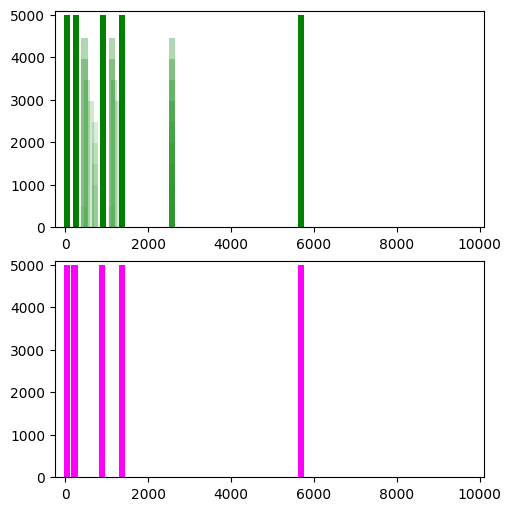

In [17]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(5, 5))

# progress of the histograms (depicted with pale colors)
alpha_value = 0.05
for i in range(0, len(boundaries_list)-1, int(len(boundaries_list)/10)):
    temp_list = boundaries_list[i][0]
    temp_height = boundaries_list[i][1]
    alpha_value = alpha_value * 1.2
    for i in range(len(temp_list)-1):
        current_el = temp_list[i]
        next_el = temp_list[i+1]
        axs[0].bar((current_el + next_el)/2, temp_height, color='green', width = 150, alpha = alpha_value)
    

# final histograms produced by the algorithm
last_list = boundaries_list[-1][0]
last_height = boundaries_list[-1][1]
for i in range(len(last_list)-1):
    current_el = last_list[i]
    next_el = last_list[i+1]
    axs[0].bar((current_el + next_el)/2, last_height, color='green', width = 150, alpha = 1)

# original histograms from the dataset
for i in range(len(temp_cp_dataset)-1):
    current_el = temp_cp_dataset[i]
    next_el = temp_cp_dataset[i+1]
    axs[1].bar((current_el + next_el)/2, step, color='magenta', width = 150, alpha = 1)

axs[0].set_ylim(0, step + 100)
axs[1].set_ylim(0, step + 100)
axs[0].set_xlim(-250, max(temp_cp_dataset) + 100)
axs[1].set_xlim(-250, max(temp_cp_dataset) + 100)
    
plt.show()